In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.7.0


In [3]:
!pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6m4jqp91
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6m4jqp91
  Resolved https://github.com/tensorflow/docs to commit 222063b041379f4d385114b9fb76f88292504858
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0222063b041379f4d385114b9fb76f88292504858_-py3-none-any.whl size=157197 sha256=2a7d42628a9857421da55181bef59e1398c5352d756b632f10c63fbf7793011d
  Stored in directory: /tmp/pip-ephem-wheel-cache-k24gavwl/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Failed to build tensorflow-docs
    Running setup.py install for tensorflow-docs ... done
  DEPRECATION: tensorflow-docs was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion re

In [4]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# The Higgs Dataset

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816417792/2816407858 [==============================] - 442s 0us/step


In [8]:
FEATURES = 28

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

2021-09-10 11:15:18.679663: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 294 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:67:00.0, compute capability: 7.5
2021-09-10 11:15:18.681179: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46569 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:68:00.0, compute capability: 7.5


In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


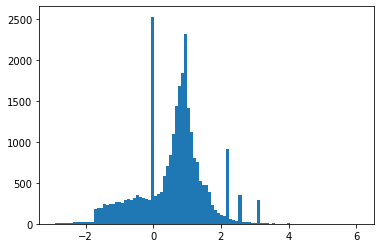

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds


<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [17]:
# overfitting

In [18]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history



# tiny model

In [20]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
_________________________________________________________________
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


2021-09-10 11:21:03.881167: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:21:03.881199: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:21:03.882120: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1630] Profiler found 2 GPUs
2021-09-10 11:21:03.882480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.4'; dlerror: libcupti.so.11.4: cannot open shared object file: No such file or directory
2021-09-10 11:21:03.882581: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory
2021-09-10 11:21:03.882593: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be 

2021-09-10 11:21:11.152932: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:21:11.152970: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:21:11.153104: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:21:11.160404: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2021-09-10 11:21:11.160544: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:21:11.167044: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-10 11:21:11.172196: I tensorflow


Epoch: 0, accuracy:0.4761,  binary_crossentropy:0.9381,  loss:0.9381,  val_accuracy:0.4810,  val_binary_crossentropy:0.7676,  val_loss:0.7676,  
....................................................................................................
Epoch: 100, accuracy:0.5842,  binary_crossentropy:0.6334,  loss:0.6334,  val_accuracy:0.5690,  val_binary_crossentropy:0.6339,  val_loss:0.6339,  
....................................................................................................
Epoch: 200, accuracy:0.6071,  binary_crossentropy:0.6217,  loss:0.6217,  val_accuracy:0.5860,  val_binary_crossentropy:0.6272,  val_loss:0.6272,  
....................................................................................................
Epoch: 300, accuracy:0.6175,  binary_crossentropy:0.6142,  loss:0.6142,  val_accuracy:0.6140,  val_binary_crossentropy:0.6212,  val_loss:0.6212,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

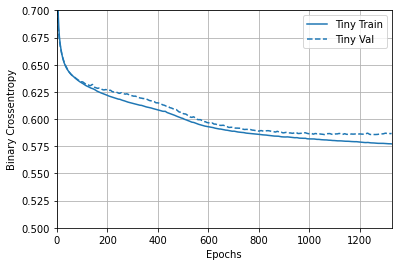

In [21]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

# small model 

In [22]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
_________________________________________________________________
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


2021-09-10 11:25:02.282511: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:25:02.282553: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:25:02.286386: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:25:02.286589: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2021-09-10 11:25:02.286619: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-10 11:25:02.581652: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:25:02.581677: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:25:02.581703: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:25:02.603816: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2021-09-10 11:25:02.603912: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:25:02.606124: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-10 11:25:02.608480: I tensorflow


Epoch: 0, accuracy:0.4651,  binary_crossentropy:0.7677,  loss:0.7677,  val_accuracy:0.4580,  val_binary_crossentropy:0.7237,  val_loss:0.7237,  
....................................................................................................
Epoch: 100, accuracy:0.6510,  binary_crossentropy:0.5976,  loss:0.5976,  val_accuracy:0.6310,  val_binary_crossentropy:0.5981,  val_loss:0.5981,  
....................................................................................................
Epoch: 200, accuracy:0.6766,  binary_crossentropy:0.5819,  loss:0.5819,  val_accuracy:0.6450,  val_binary_crossentropy:0.5968,  val_loss:0.5968,  
....................................................................................................
Epoch: 300, accuracy:0.6897,  binary_crossentropy:0.5711,  loss:0.5711,  val_accuracy:0.6710,  val_binary_crossentropy:0.5889,  val_loss:0.5889,  
....................................................................................................
Epoch: 40

# medium model 

In [23]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
_________________________________________________________________
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


2021-09-10 11:26:45.970669: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:26:45.970701: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:26:45.972673: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:26:45.972926: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2021-09-10 11:26:45.972969: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-10 11:26:46.343626: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:26:46.343651: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:26:46.343677: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:26:46.367189: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2021-09-10 11:26:46.367289: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:26:46.369601: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-10 11:26:46.372001: I tensorflow


Epoch: 0, accuracy:0.4815,  binary_crossentropy:0.7042,  loss:0.7042,  val_accuracy:0.4740,  val_binary_crossentropy:0.6853,  val_loss:0.6853,  
....................................................................................................
Epoch: 100, accuracy:0.7162,  binary_crossentropy:0.5282,  loss:0.5282,  val_accuracy:0.6540,  val_binary_crossentropy:0.6020,  val_loss:0.6020,  
....................................................................................................
Epoch: 200, accuracy:0.7939,  binary_crossentropy:0.4195,  loss:0.4195,  val_accuracy:0.6640,  val_binary_crossentropy:0.6687,  val_loss:0.6687,  
..........................................................................................

# large model 

In [24]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
_________________________________________________________________
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2021-09-10 11:27:33.768386: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:27:33.768420: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:27:33.771274: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:27:33.771375: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2021-09-10 11:27:33.771422: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-10 11:27:34.140250: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:27:34.140275: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:27:34.140317: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:27:34.165630: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2021-09-10 11:27:34.165734: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:27:34.168153: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-10 11:27:34.170534: I tensorflow


Epoch: 0, accuracy:0.5085,  binary_crossentropy:0.8258,  loss:0.8258,  val_accuracy:0.4830,  val_binary_crossentropy:0.6857,  val_loss:0.6857,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0023,  loss:0.0023,  val_accuracy:0.6560,  val_binary_crossentropy:1.7952,  val_loss:1.7952,  
....................................................................................................
Epoch: 200, accuracy:1.0000,  binary_crossentropy:0.0001,  loss:0.0001,  val_accuracy:0.6650,  val_binary_crossentropy:2.4500,  val_loss:2.4500,  
................................

# plot the training and validation losses

Text(0.5, 0, 'Epochs [Log Scale]')

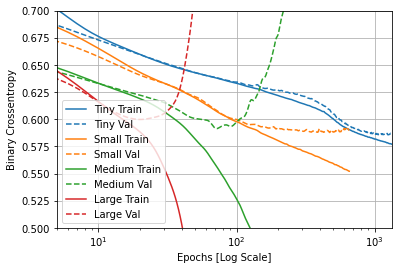

In [25]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

# view in tesorboard

In [32]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes --load_fast=false

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 254735), started 0:01:00 ago. (Use '!kill 254735' to kill it.)

In [31]:
print(logdir)

/tmp/tmpz_5wn94q/tensorboard_logs


# Strategies to prevent overfitting

In [33]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpz_5wn94q/tensorboard_logs/regularizers/Tiny')

In [34]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### L2 weight regularization

In [35]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
_________________________________________________________________
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2021-09-10 11:46:08.855328: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:46:08.855362: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:46:08.857768: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:46:08.857788: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2021-09-10 11:46:08.857804: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-10 11:46:09.260137: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:46:09.260172: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:46:09.260208: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:46:09.298405: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2021-09-10 11:46:09.298524: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:46:09.300975: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-10 11:46:09.303460: I tensorflow


Epoch: 0, accuracy:0.5059,  binary_crossentropy:0.8413,  loss:2.3635,  val_accuracy:0.4710,  val_binary_crossentropy:0.6885,  val_loss:2.1390,  
....................................................................................................
Epoch: 100, accuracy:0.6641,  binary_crossentropy:0.5924,  loss:0.6171,  val_accuracy:0.6330,  val_binary_crossentropy:0.5834,  val_loss:0.6080,  
....................................................................................................
Epoch: 200, accuracy:0.6806,  binary_crossentropy:0.5795,  loss:0.6025,  val_accuracy:0.6750,  val_binary_crossentropy:0.5755,  val_loss:0.5985,  
....................................................................................................
Epoch: 300, accuracy:0.6782,  binary_crossentropy:0.5747,  loss:0.5977,  val_accuracy:0.6650,  val_binary_crossentropy:0.5795,  val_loss:0.6029,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

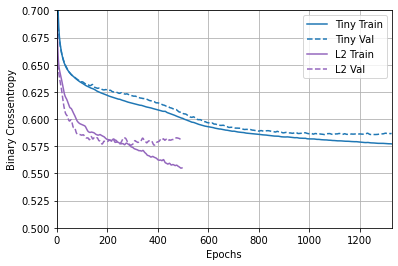

In [36]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

### drop out

In [37]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)              

2021-09-10 11:50:09.757706: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:50:09.757746: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:50:09.757935: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:50:09.757998: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2021-09-10 11:50:09.758087: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-10 11:50:10.145524: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:50:10.145549: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:50:10.145650: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:50:10.197275: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2021-09-10 11:50:10.197409: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:50:10.199941: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-10 11:50:10.202382: I tensorflow


Epoch: 0, accuracy:0.5046,  binary_crossentropy:0.8008,  loss:0.8008,  val_accuracy:0.5190,  val_binary_crossentropy:0.6693,  val_loss:0.6693,  
....................................................................................................
Epoch: 100, accuracy:0.6565,  binary_crossentropy:0.5954,  loss:0.5954,  val_accuracy:0.6760,  val_binary_crossentropy:0.5773,  val_loss:0.5773,  
....................................................................................................
Epoch: 200, accuracy:0.6887,  binary_crossentropy:0.5532,  loss:0.5532,  val_accuracy:0.6880,  val_binary_crossentropy:0.5778,  val_loss:0.5778,  
....................................................................................................
Epoch: 300, accuracy:0.7217,  binary_crossentropy:0.5136,  loss:0.5136,  val_accuracy:0.6920,  val_binary_crossentropy:0.5879,  val_loss:0.5879,  
.......................................................................................

(0.5, 0.7)

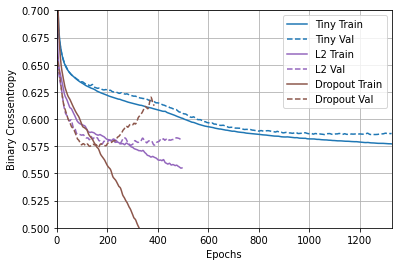

In [38]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

# L2 + dropout 

In [39]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)              

2021-09-10 11:51:20.394271: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:51:20.394297: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:51:20.394411: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:51:20.394749: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2021-09-10 11:51:20.394765: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


2021-09-10 11:51:20.831081: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2021-09-10 11:51:20.831107: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2021-09-10 11:51:20.831135: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1681] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:51:20.863803: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2021-09-10 11:51:20.863929: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1773] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-09-10 11:51:20.866544: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:526]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-09-10 11:51:20.868928: I tensorflow


Epoch: 0, accuracy:0.5104,  binary_crossentropy:0.7903,  loss:0.9484,  val_accuracy:0.5340,  val_binary_crossentropy:0.6858,  val_loss:0.8433,  
....................................................................................................
Epoch: 100, accuracy:0.6469,  binary_crossentropy:0.6046,  loss:0.6337,  val_accuracy:0.6590,  val_binary_crossentropy:0.5843,  val_loss:0.6132,  
....................................................................................................
Epoch: 200, accuracy:0.6616,  binary_crossentropy:0.5927,  loss:0.6179,  val_accuracy:0.6820,  val_binary_crossentropy:0.5703,  val_loss:0.5955,  
....................................................................................................
Epoch: 300, accuracy:0.6708,  binary_crossentropy:0.5856,  loss:0.6129,  val_accuracy:0.6740,  val_binary_crossentropy:0.5623,  val_loss:0.5896,  
....................................................................................................
Epoch: 40

(0.5, 0.7)

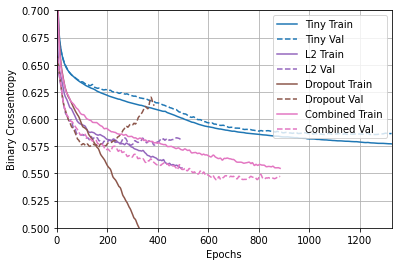

In [40]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [41]:
%tensorboard --logdir {logdir}/regularizers

Conclusions
To recap: here are the most common ways to prevent overfitting in neural networks:

Get more training data.
Reduce the capacity of the network.
Add weight regularization.
Add dropout.
Two important approaches not covered in this guide are:

data-augmentation  => later in advanced tutorial

batch normalization => this will be implemented in futher exercise

Remember that each method can help on its own, but often combining them can be even more effective.


